In [1]:
##Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)
sns.set(style='darkgrid')
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker


# import all libraries and dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.compose import make_column_transformer


import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats
from scipy.stats import norm, kurtosis, skew

# Import specific libraries
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('expand_frame_repr', False)



In [ ]:
##FILTRAR: mas_cols  = all_data.filter(like='Mas', axis=1).columns

In [2]:
#Loading updated dataset

%store -r all_data
%store -r y_train

In [3]:
##Se crea un feature con todos los ordinales, los cuales son relativos a la calidad de la infraestructura
all_data["TotalPoints"] = (all_data.ExterQual + all_data.FireplaceQu + all_data.GarageQual + all_data.KitchenQual +
                            all_data.BsmtQual + all_data.BsmtExposure + all_data.BsmtFinType1 + all_data.PoolQC + 
                            all_data.ExterCond + all_data.BsmtCond + all_data.GarageCond + all_data.OverallCond +
                            all_data.BsmtFinType2 + all_data.HeatingQC) + all_data.OverallQual**2

##Se crea un feature que agrega los puntajes de todos los extras dentro la infarestructura
all_data["TotalExtraPoints"] = all_data.HeatingQC + all_data.PoolQC + all_data.FireplaceQu  + all_data.KitchenQual

In [4]:
def plot_vars(cols, t, target):
    sns.reset_defaults()
    sns.set(style="ticks", color_codes=True)
    fig = plt.figure(figsize = (10,20))
    i = 1
    for col in cols:
        fig_i= fig.add_subplot(9,2,i)
        sns.regplot( x= col, y = target, data = t )
        plt.title("Correlation to target:{:1.4f}".format(t[col].corr(t[target])))
        i +=1
        plt.show()

In [5]:
##Creamos dataset para analizar qué tan buenos son estos dos features
df = all_data.iloc[:len(y_train), :]
df["SalePrice"] = y_train

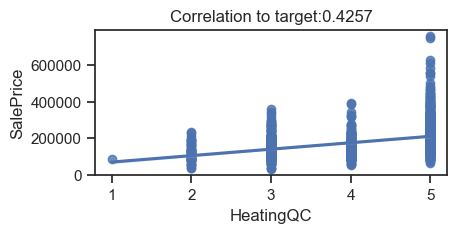

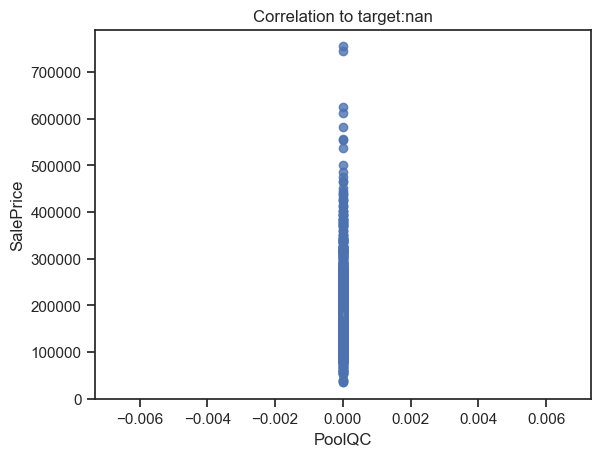

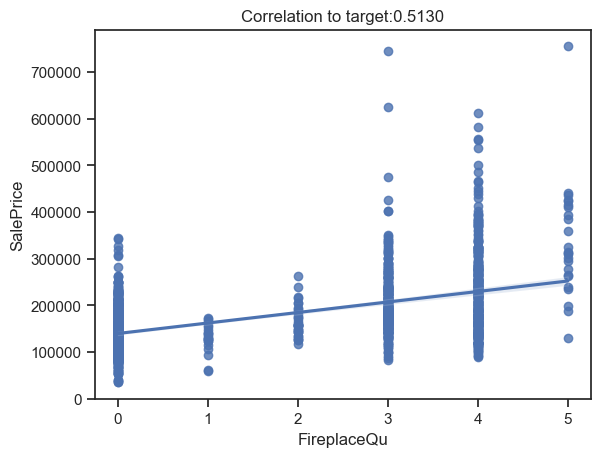

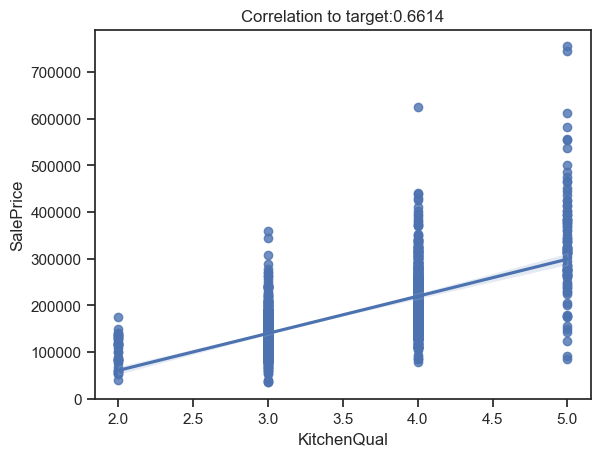

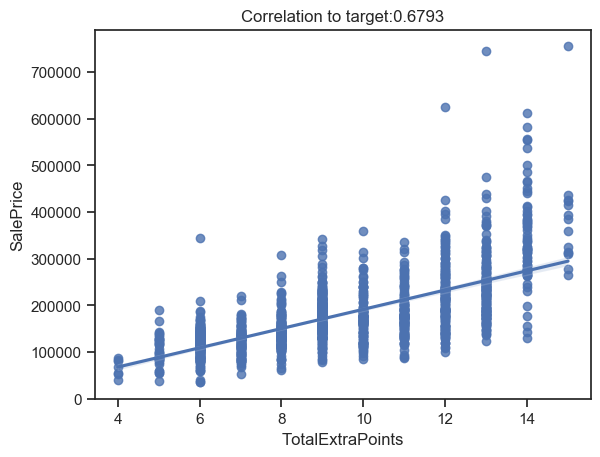

In [6]:
##Analisis gráfico y de correlación...
col_extra = ["HeatingQC",  "PoolQC",  "FireplaceQu",   "KitchenQual", "TotalExtraPoints"]
plot_vars(col_extra, df, "SalePrice")

##Se ve que extrapoints aporta una mayor correlación que todos los feats individuales

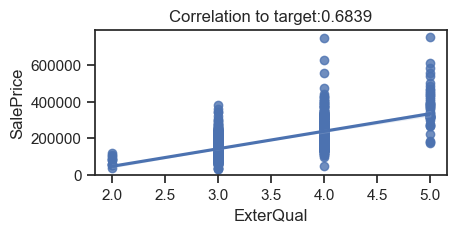

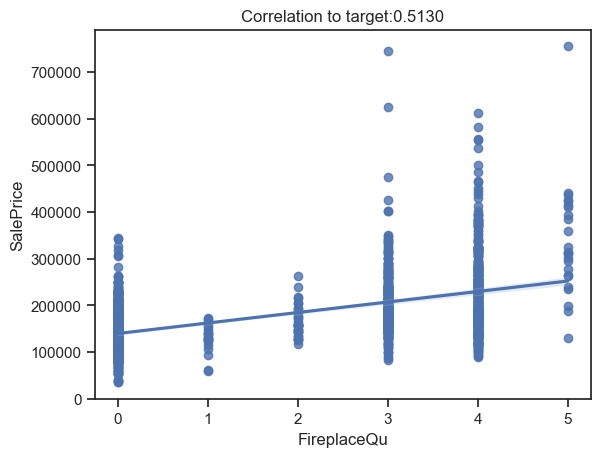

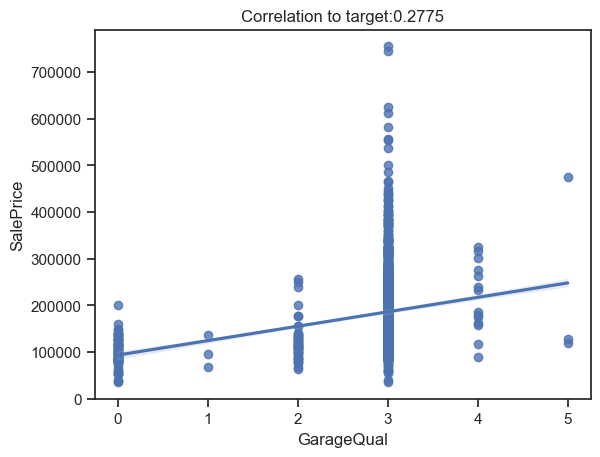

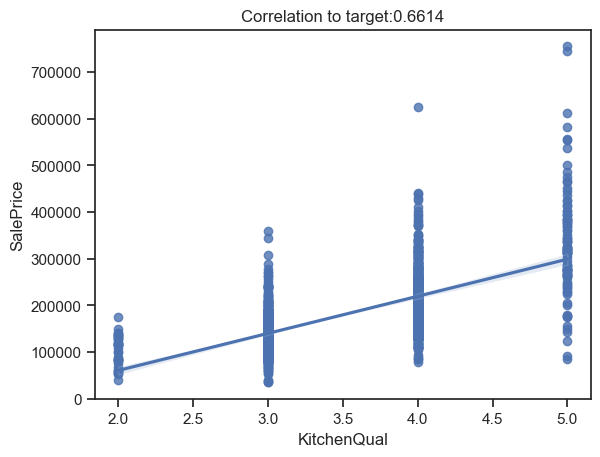

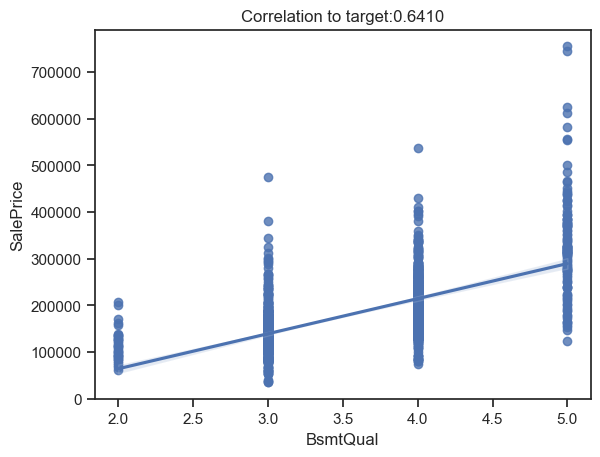

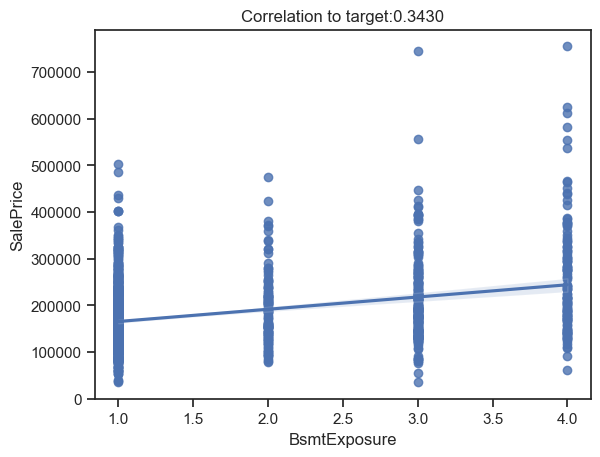

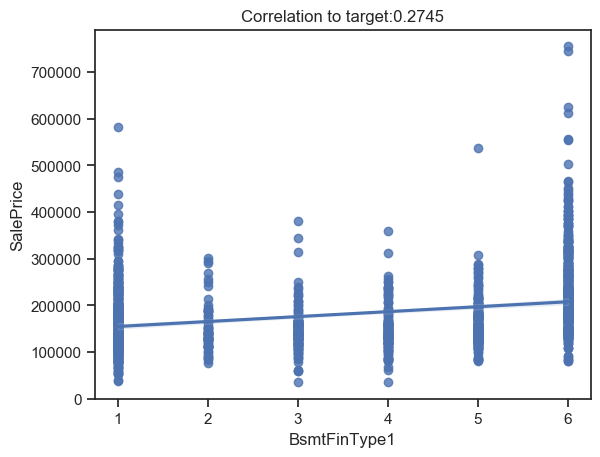

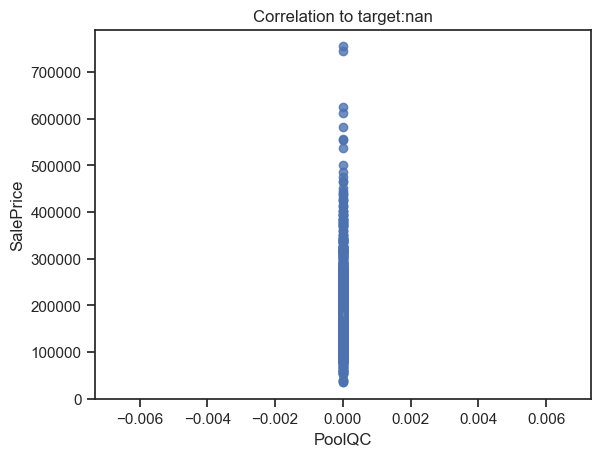

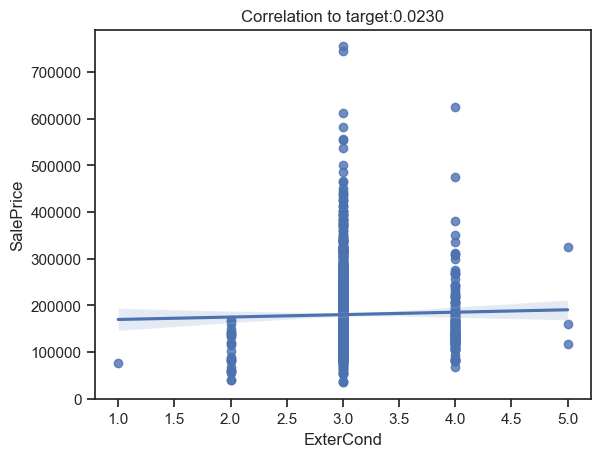

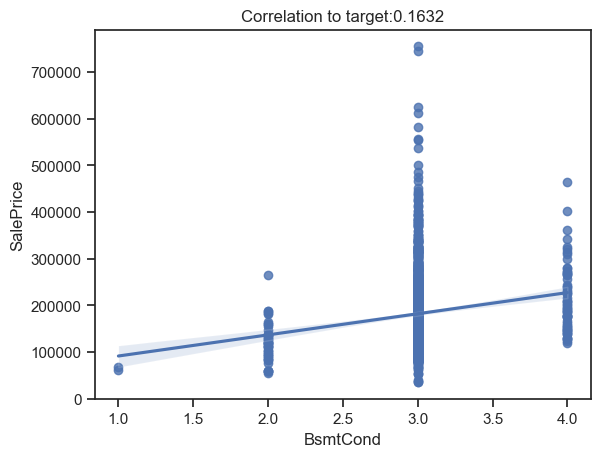

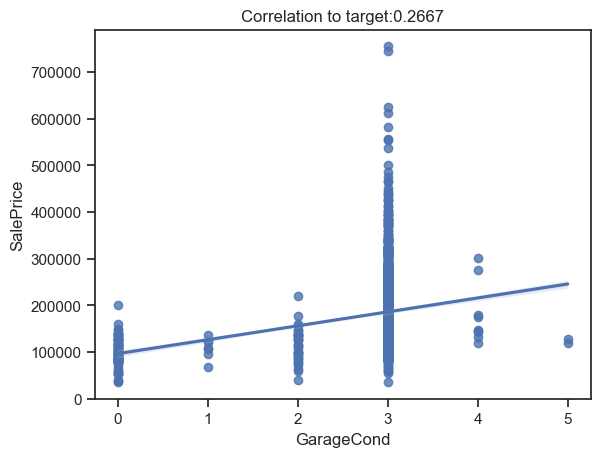

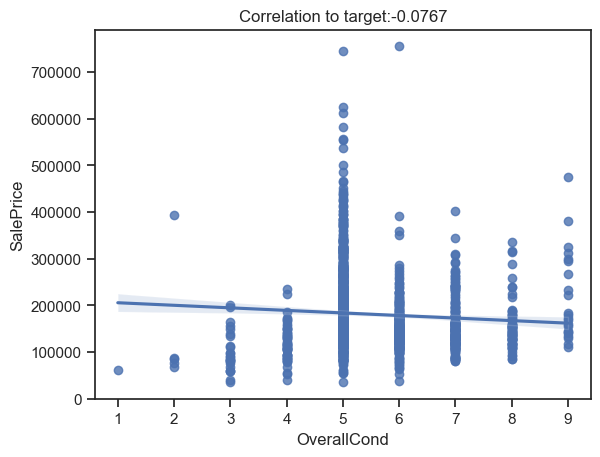

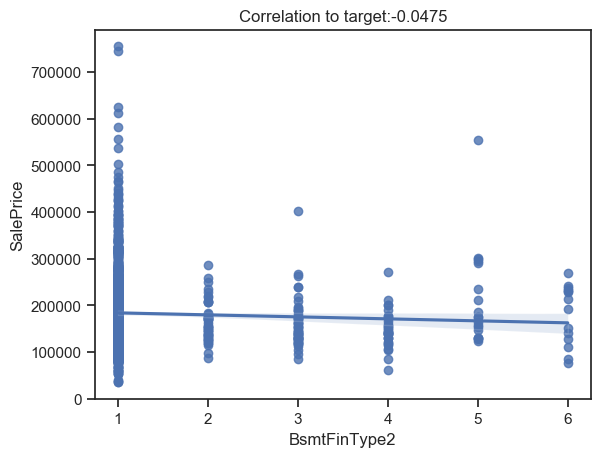

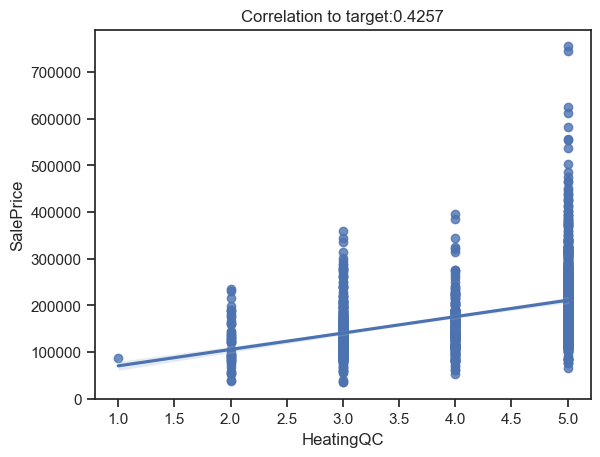

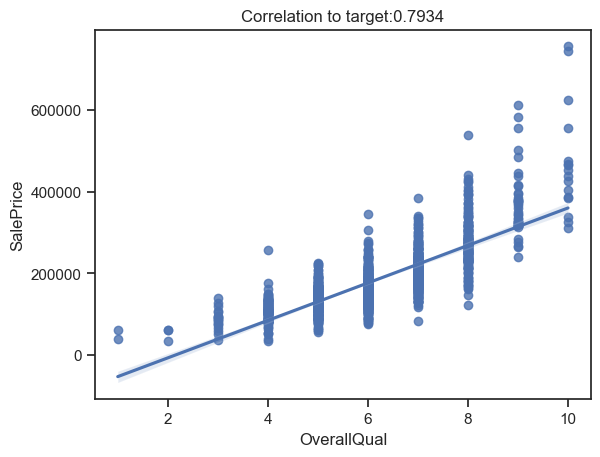

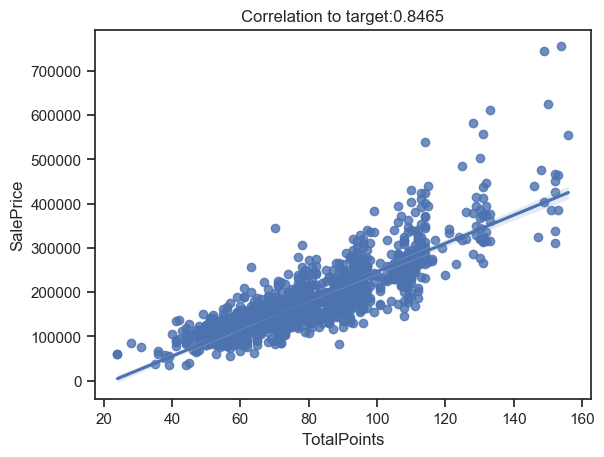

In [7]:
col_total = ["ExterQual" , "FireplaceQu" , "GarageQual" , "KitchenQual" ,
                            "BsmtQual" , "BsmtExposure" , "BsmtFinType1" , "PoolQC" , 
                            "ExterCond" , "BsmtCond" , "GarageCond" , "OverallCond" ,
                            "BsmtFinType2" , "HeatingQC" , "OverallQual", "TotalPoints"]
plot_vars(col_total, df, "SalePrice")

In [8]:
#Total points arroja una bella distribución con una correlación de .84 baja varianza

In [9]:
#Agregamos otros new features que habíamos creado y otros más que se le ocurrieron a Copetition
new_features = ['GarageArea * GarageCars','TotalBsmt * 1stFlrSF','YearBuilt * YearRemodAdd','TotalBathrooms',
 'TotalPorch','Area*Slope']
#Garagearea*Car
all_data["GarageArea_x_Car"] = all_data["GarageArea"] * all_data["GarageCars"]

#TotalBsmtx1stflr
all_data["TotalBsmtSF_x_Bsm"] = all_data["TotalBsmtSF"] * all_data["1stFlrSF"]

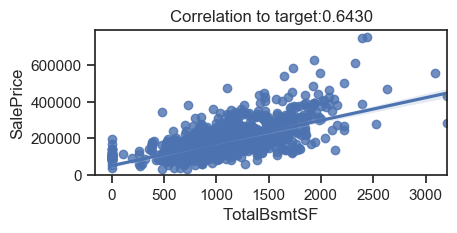

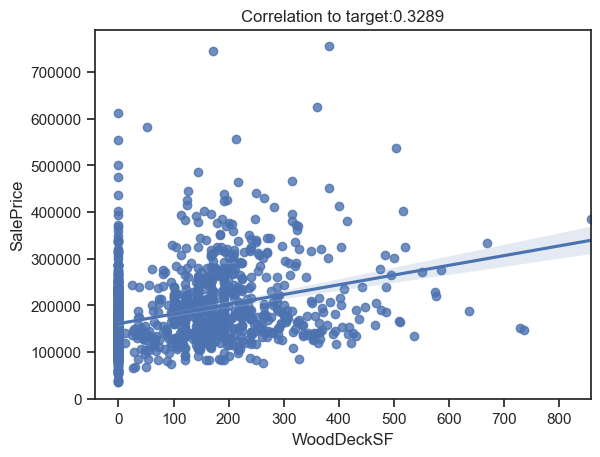

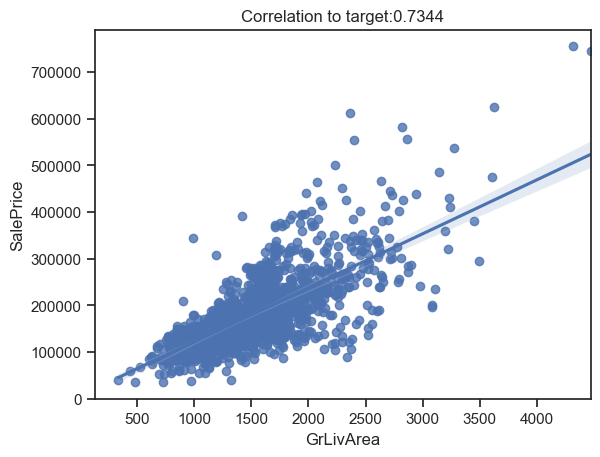

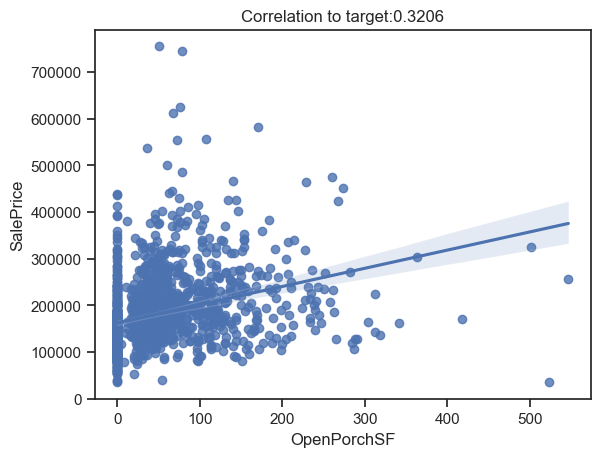

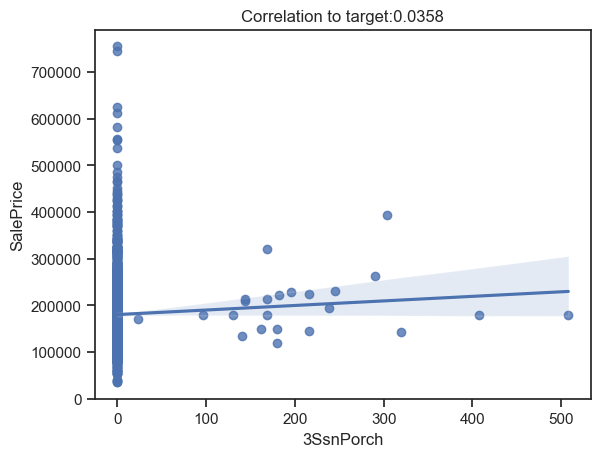

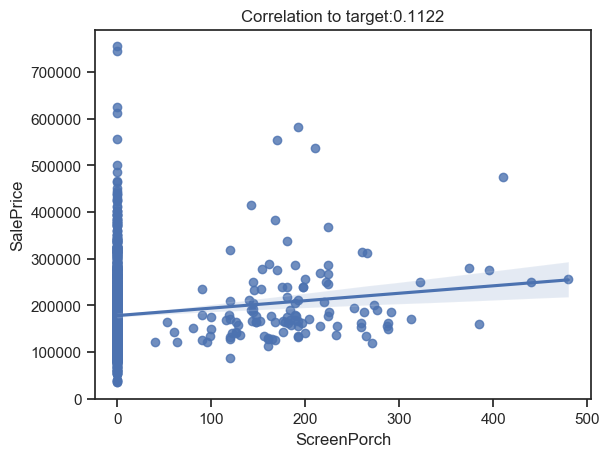

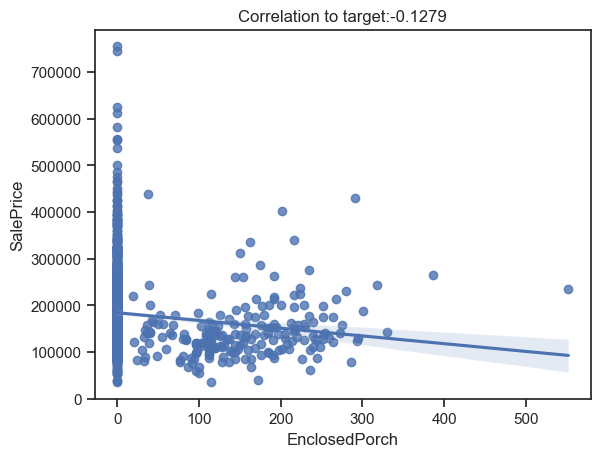

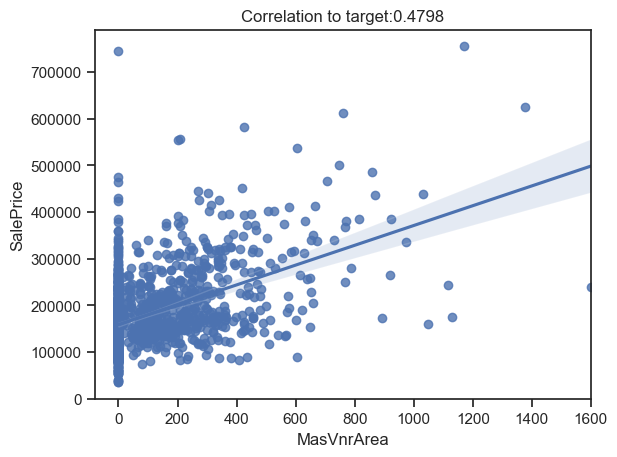

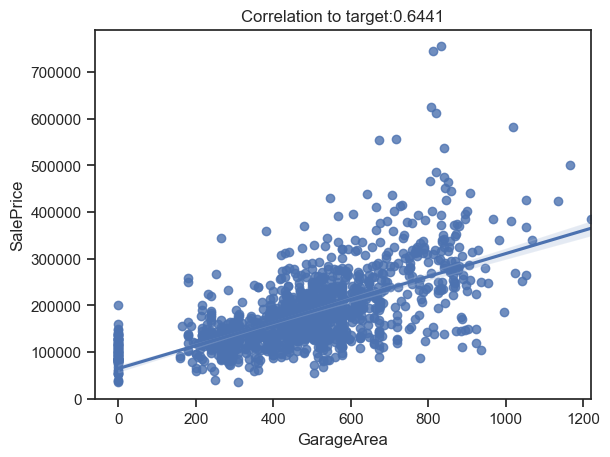

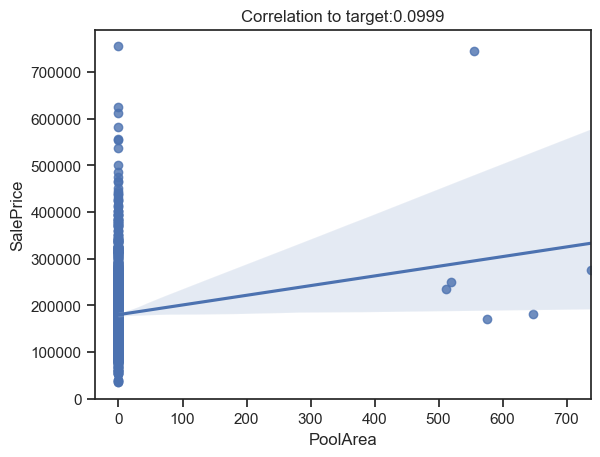

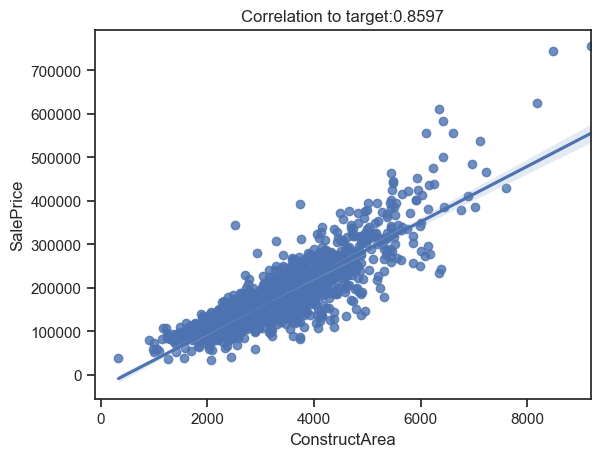

In [12]:
#Se crea un feature de area total de construccion
#Antes hay que convertir bsmtsf a int, porque es object
all_data["TotalBsmtSF"] = all_data["TotalBsmtSF"].astype("float64")
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea +
                             all_data.OpenPorchSF + all_data["3SsnPorch"] + all_data.ScreenPorch + all_data.EnclosedPorch +
                             all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea )

#Testeamos qué tal se comporta...
df = all_data.iloc[:len(y_train), :]
df["SalePrice"] = y_train
col_const = ["TotalBsmtSF" , "WoodDeckSF" , "GrLivArea" ,
                             "OpenPorchSF" , "3SsnPorch" , "ScreenPorch" , "EnclosedPorch" ,
                             "MasVnrArea" , "GarageArea" , "PoolArea", "ConstructArea" ]
plot_vars(col_const, df, "SalePrice")


In [ ]:
#3Muy buena correlacion de 0.86 en ConstructArea

In [13]:
new_features

['GarageArea * GarageCars',
 'TotalBsmt * 1stFlrSF',
 'YearBuilt * YearRemodAdd',
 'TotalBathrooms',
 'TotalPorch',
 'Area*Slope']

In [34]:
#TotalPorch
all_data["TotalPorch"] =  all_data["OpenPorchSF"] + all_data['EnclosedPorch']+ all_data['3SsnPorch'] 
+ all_data['ScreenPorch'] + all_data['WoodDeckSF']

#binarizacion de EnclosedPorch. NO se por qué no se hizo loo mismo con los otros features
all_data["EnclosedPorch"] = all_data["EnclosedPorch"].apply(lambda x: 1 if x else 0)

In [22]:
#GarageNewest
all_data["GarageNewest"] = all_data["YearBuilt"] > all_data["GarageYrBlt"]

#Eso me deja en True/False
all_data["GarageNewest"] = all_data["GarageNewest"].apply(lambda x: 1 if x else 0) # 1 si es True

In [41]:
#LotAreaMultSlope
all_data["LotAreaMultSlope"] = all_data["LotArea"] * all_data["LandSlope"]

In [ ]:
#BsmtSFPoints

In [46]:
all_data["BsmtSFPoints"] = all_data["BsmtQual"]**2 + all_data["BsmtCond"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] 

In [47]:
#['BsmtSFMultPoints']
all_data['BsmtSFMultPoints'] = all_data["TotalBsmtSF"] * (all_data["BsmtQual"]**2 + all_data["BsmtCond"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] )

In [56]:
#TotalBathrooms
#Antes tengo que convertir dos features a numerico
all_data["BsmtFullBath"] = all_data["BsmtFullBath"].astype("int64")
all_data["BsmtHalfBath"] = all_data["BsmtHalfBath"].astype("int64")

all_data["TotBathrooms"] = all_data["FullBath"] + + all_data["HalfBath"] * 0.5 + all_data["BsmtFullBath"] + all_data["BsmtHalfBath"] * 0.5

In [58]:
#Binarizacion de todos los bath del feature nuevo anterior
mas_cols  = all_data.filter(like='Bath', axis=1).columns
for c in mas_cols:
    all_data[c] = all_data[c].apply(lambda x: 1 if x else 0)

In [59]:
all_data[mas_cols].head()

BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  TotBathrooms
0  1             0             1         1         1           
1  0             1             1         0         1           
2  1             0             1         1         1           
3  1             0             1         0         1           
4  1             0             1         1         1

In [ ]:
##One hot encoding here....